In [34]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import random
import json
import re
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
matplotlib.style.use('ggplot')
pd.set_option('max_colwidth',50)
import torch
from collections import Counter

from loguru import logger

# 数据的预处理

In [2]:
fname = 'data/processed/train.jsonl'

In [3]:
d = list(json.loads(x) for x in open(fname, 'r', encoding='utf-8').read().strip().split('\n'))
df = pd.DataFrame(d)

## 寻找共现标签并删除

### 寻找共现标签

##### 读取

In [4]:
d = list(json.loads(x) for x in open(fname, 'r', encoding='utf-8').read().strip().split('\n'))
df = pd.DataFrame(d)

In [5]:
b = df['label'].apply(lambda x: 'label_123' in x)

In [6]:
b.to_numpy().astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [7]:
# 获取所有label的set
label_set = set()
for e in df['label']:
    for e_label in e: label_set.add(e_label)

# 每一个label在句子中出现的布尔向量
# 将布尔向量改为10，作为二进制数转化为int，作为该label的fingerprint
s = df.shape[0]
label2binary = {}  # label -> fingerprint
fp2label = {}
for e in tqdm(label_set):
    pos_bool = df['label'].apply(lambda x: e in x).to_numpy().astype(int).tolist()
    fingerprint = int(''.join(list(str(x) for x in pos_bool)))
    if fingerprint not in fp2label:
        fp2label[fingerprint] = [e]
    else:
        fp2label[fingerprint].append(e)

# 找到fingerprint相同的label
same_groups = []
for v in fp2label.values():
    if len(v) >= 2:
        same_groups.append(v)

100%|██████████| 1399/1399 [00:49<00:00, 28.47it/s]


In [8]:
label2equivalent = {}
for e in same_groups:
    label2equivalent[e[0]] = e[1:]

In [9]:
json.dump(same_groups, open('temp_data/equivalent_labels.json', 'w', encoding='utf-8'))
json.dump(label2equivalent, open('temp_data/label2equivalent.json', 'w', encoding='utf-8'))

### 读取共现标签

In [4]:
same_groups = json.load(open('temp_data/equivalent_labels.json', 'r', encoding='utf-8'))
label2equivalent = json.load(open('temp_data/label2equivalent.json', 'r', encoding='utf-8'))

### 删除df中的一致标签

In [6]:
delete_set = set()
for e in same_groups:
    for d in e[1:]:
        delete_set.add(d)

In [7]:
def update_list(l):
    new_list = []
    for e in l:
        if e not in delete_set:
            new_list.append(e)
    return new_list

In [8]:
filtered_df = df.copy()
filtered_df['label'] = filtered_df['label'].apply(update_list)

In [9]:
filtered_df.to_pickle('temp_data/filtered_df.pkl')

### 读取

In [186]:
filtered_df = pd.read_pickle('temp_data/filtered_df.pkl')

## 删除单一样本

In [190]:
label_df = filtered_df.explode('label')['label'].value_counts()
single_labels = list(label_df[label_df == 1].index)
temp_df = filtered_df.copy()
temp_df['status'] = temp_df['label'].apply(lambda x: len(x) == 1 and x[0] in single_labels)
filtered_df = filtered_df.drop(temp_df[temp_df['status']].index)
json.dump(single_labels, open('temp_data/single_labels.json', 'w', encoding='utf-8'))

In [192]:
len(single_labels)

0

## 删除成员过于相似的标签

### 编辑距离

In [24]:
def edit_distance(string_a, string_b):
    """编辑距离"""
    m = len(string_a)
    n = len(string_b)
    dp = [[0 for _ in range(m + 1)] for _ in range(n + 1)]
    # 从空位置变到string_a每个位置的距离
    for col in range(m + 1):
        dp[0][col] = col
    # 从空位置变到string_b 每个位置的距离
    for row in range(n + 1):
        dp[row][0] = row

    # 填表
    for row in range(1, n+1):
        for col in range(1, m+1):
            if string_a[col-1] != string_b[row-1]:
                dp[row][col] = min(dp[row - 1][col], dp[row - 1][col-1], dp[row][col-1]) + 1
            else:
                dp[row][col] = dp[row-1][col-1]
    return dp[n][m]

def similarity(sentences, max_size = 100):
    l = len(sentences)
    if l > max_size:
        idxes = random.sample(list(range(l)), max_size)
    else:
        idxes = list(range(l))
    scores = []
    for i in tqdm(range(len(idxes))):
        for j in range(i, len(idxes)):
            ed = edit_distance(sentences[idxes[i]], sentences[idxes[j]])
            ed_score = ed / ((len(sentences[idxes[i]]) + len(sentences[idxes[j]]) / 2))
            scores.append(ed_score)
    return sum(scores) / len(scores)

In [25]:
sim_df = filtered_df.explode('label').groupby('label').apply(lambda x: similarity(list(x['text'])))

100%|██████████| 20/20 [00:00<00:00, 53.20it/s]


In [215]:
sim_df.to_csv('temp_data/editdis_sim_df.csv')

In [68]:
sim_df.describe()

count    1018.000000
mean        0.560279
std         0.184925
min         0.003132
25%         0.497876
50%         0.601706
75%         0.681853
max         0.861278
dtype: float64

In [253]:
sim_list = list(sim_df[sim_df > 0.35].sort_values().index)
json.dump(sim_list, open('temp_data/class_3_labels.json', 'w', encoding='utf-8'))

### BLEU

### 删除
选择删除sim分数低于0.35的所有标签

In [183]:
sim_set = set(sim_df[sim_df > 0.35].sort_values().index)

In [200]:
not_conatain_sim = filtered_df['label'].apply(lambda x: len(set(x).intersection(sim_set)) == 0)
filtered_df = filtered_df.drop(filtered_df[not_conatain_sim].index)

In [201]:
filtered_df

,id,text,label
0,0,原来是这样啊，又是一个新的道理，简直让我长知识了，七星连珠是很难得的一种现象，这个解析也太到位了,[label_878402]
1,1,老师好厉害，咱就是说，老师，能不能，就是，研究一下能不能穿越🙏 代入感很强，我已经想穿越去...,[label_878402]
2,2,这个七星连珠的现象居然真的存在，我只在小说上面看过，太神奇了吧，至于其他的我也不太懂，科学现...,[label_878402]
3,3,应该听过张老师讲，这一个的人都会觉得特别的清晰吧，而且也明白七星连珠不会引发危害。 ​,[label_878402]
4,4,七星连珠这不是应该是天文知识吗，怎么物理也可以，学霸的世界我果然不懂啊,[label_878402]
...,...,...,...
77309,77309,甘肃兰州2022年文化和自然遗产日主场城市活动亮点抢先看甘肃兰州2022年文化和自然遗产日主...,[label_82331]
77310,77310,《焦点访谈》 20220611 让文物活起来 国宝自己会“说话” 《焦点访谈》 202206...,[label_82331]
77311,77311,甘肃加大农机装备力量投入“三夏”生产网页链接,[label_82331]
77312,77312,小范书记们，村民都在等荐书 网页链接 ​​​,[label_82331]


## 包含“超话”的句子实验

In [55]:
filtered_df = pd.read_pickle('temp_data/filtered_df.pkl')

In [51]:
def get_topic(sent):
    splits = [' ', '\t', ',', '.', '，', '。', '！', '？', '?', '!', ';', '；']
    words = re.split(f'[{"|".join(splits)}]', sent)
    for e in words:
        ee = e.split('超话')
        if len(ee) > 1:
            return ee[0]
    return ' '

In [56]:
filtered_df['super_topic'] = filtered_df['text'].apply(get_topic)

In [63]:
filtered_df['super_topic'].value_counts().describe()

count      952.000000
mean        81.212185
std       2053.430740
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      62937.000000
Name: super_topic, dtype: float64

## 分词

### 直接分词

In [202]:
import jieba

In [203]:
df_splitted = filtered_df.copy()
df_splitted['splitted'] = df_splitted['text'].apply(lambda x: list(jieba.cut(x)))

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/v2/_14t7h052kgc9sf4crk2qb000000gn/T/jieba.cache
Loading model cost 0.538 seconds.
Prefix dict has been built successfully.


In [214]:
df_splitted.to_csv('temp_data/df_splitted_clean.csv')

### 构造词表

In [205]:
vocabulary = set()
for e in tqdm(df_splitted['splitted']):
    vocabulary = vocabulary.union(set(e))
vocabulary = sorted(list(vocabulary))
vocabulary_idx = {x: i for i, x in enumerate(vocabulary)}
json.dump(vocabulary, open('temp_data/vocabulary.json', 'w', encoding='utf-8'))
json.dump(vocabulary_idx, open('temp_data/vocabulary_idx.json', 'w', encoding='utf-8'))

100%|██████████| 73157/73157 [01:20<00:00, 906.98it/s] 


In [206]:
vocabulary = json.load(open('temp_data/vocabulary.json', 'r', encoding='utf-8'))
vocabulary_idx = json.load(open('temp_data/vocabulary_idx.json', 'r', encoding='utf-8'))

### 构造词语在句子中的出现矩阵

In [18]:
df_splitted['splitted'][2]

['这个',
 '七星',
 '连珠',
 '的',
 '现象',
 '居然',
 '真的',
 '存在',
 '，',
 '我',
 '只',
 '在',
 '小说',
 '上面',
 '看过',
 '，',
 '太',
 '神奇',
 '了',
 '吧',
 '，',
 '至于',
 '其他',
 '的',
 '我',
 '也',
 '不',
 '太',
 '懂',
 '，',
 '科学',
 '现象',
 '还是',
 '需要',
 '很多',
 '依据',
 '证明',
 '的']

In [207]:
# shape=(vocab, sentence cnt)，词语在句子中的出现矩阵
vocab_appear = np.zeros((len(vocabulary), df_splitted.shape[0]), dtype=bool)
for i, row in tqdm(enumerate(df_splitted['splitted'])):
    for w in row:
        w_idx = vocabulary_idx[w]
        vocab_appear[w_idx][i] = True

73157it [00:01, 55276.66it/s]


In [20]:
np.save('temp_data/csr_vocab_appear', csr_vocab_appear)

# 关键词方案

In [56]:
csr_vocab_appear = np.load('temp_data/csr_vocab_appear.npy', allow_pickle=True)
vocab_appear = csr_vocab_appear.todense()
df_splitted = pd.read_pickle('temp_data/df_splitted.pkl')

ValueError: Object arrays cannot be loaded when allow_pickle=False

## 构造标签矩阵

### 标签表

In [208]:
label_vocabulary = []
for e in tqdm(df_splitted['label']):
    label_vocabulary.extend(e)
label_count = sorted(list(Counter(label_vocabulary).items()))
label_vocabulary = list(x[0] for x in label_count)
label_count = list(x[1] for x in label_count)
label_vocabulary_idx = {x: i for i, x in enumerate(label_vocabulary)}

json.dump(label_vocabulary, open('temp_data/label_vocabulary.json', 'w', encoding='utf-8'))
json.dump(label_vocabulary_idx, open('temp_data/label_vocabulary_idx.json', 'w', encoding='utf-8'))
json.dump(label_count, open('temp_data/label_count.json', 'w', encoding='utf-8'))

100%|██████████| 73157/73157 [00:00<00:00, 2567914.72it/s]


### 标签在句子中的出现

In [209]:
# shape=(label_vocab, sentence cnt) 标签在句子中的出现矩阵
label_appear = np.zeros((len(label_vocabulary), df_splitted.shape[0]), dtype=bool)
for i, row in tqdm(enumerate(df_splitted['label'])):
    for l in row:
        l_idx = label_vocabulary_idx[l]
        label_appear[l_idx][i] = True

73157it [00:00, 1453975.83it/s]


In [23]:
np.save('temp_data/csr_label_appear', csr_label_appear)

In [211]:
vocab_appear.shape, label_appear.shape

((86066, 73157), (902, 73157))

In [230]:
word_in_label = frag_matmul(vocab_appear, label_appear.T, 300)

100%|██████████| 287/287 [00:00<00:00, 558.11it/s]


In [231]:
word_not_in_label = frag_matmul(vocab_appear, ~label_appear.T, 300)

100%|██████████| 287/287 [00:00<00:00, 514.38it/s]


### 验证标签矩阵和词矩阵的正确和一致性

In [25]:
vocab_info = np.where(vocab_appear)
v_idx, s_idx = vocab_info[0], vocab_info[1]
for elem_vidx, elem_sidx in tqdm(list(zip(v_idx, s_idx))):
    cur_word = vocabulary[elem_vidx]
    assert cur_word in df_splitted['splitted'][elem_sidx]

100%|██████████| 2012049/2012049 [00:08<00:00, 249823.71it/s]


In [26]:
label_info = np.where(label_appear)
l_idx, s_idx = label_info[0], label_info[1]
for elem_lidx, elem_sidx in tqdm(list(zip(l_idx, s_idx))):
    cur_label = label_vocabulary[elem_lidx]
    assert cur_label in df_splitted['label'][elem_sidx]

100%|██████████| 97791/97791 [00:00<00:00, 294765.41it/s]


In [229]:
def frag_matmul(a, b, max_dim=100, verbose=False, use_cuda=False):
    # a = (a1, m), b = (m, b2)
    # 将a1和a2化为多个长为100的block
    a_rows, b_columns = [], []
    
    if verbose:
        logger.info('正在碎片化')
    dim_a, dim_b = a.shape[0], b.shape[1]
    a_frag_cnt = (dim_a + max_dim - 1) // max_dim
    b_frag_cnt = (dim_b + max_dim - 1) // max_dim
    for ia in range(a_frag_cnt):
        a_rows.append(a[ia * max_dim: min((ia + 1) * max_dim, a.shape[0])].astype(int))
    for ib in range(b_frag_cnt):
        b_columns.append(b[:, ib * max_dim: min((ib + 1) * max_dim, b.shape[1])].astype(int))
    
    results = []
    if verbose:
        logger.info('正在将碎片进行矩阵乘法')
    if use_cuda:
        for i_r in tqdm(range(a_frag_cnt)):
            results.append([])
            for i_c in range(b_frag_cnt):
                cur_a_row = torch.tensor(a_rows[i_r]).to(torch.float).to('cuda')
                cur_b_column = torch.tensor(b_columns[i_c]).to(torch.float).to('cuda')
                res = torch.matmul(cur_a_row, cur_b_column)
                results[-1].append(np.array(res.cpu(), dtype=int))
    else:
        for i_r in tqdm(range(a_frag_cnt)):
            results.append([])
            for i_c in range(b_frag_cnt):
                results[-1].append(np.matmul(a_rows[i_r], b_columns[i_c]))
    
    
    if verbose: logger.info('正在合并碎片')
    np_rows = []
    for erow in tqdm(results):
        np_rows.append(np.concatenate(erow, axis=1))
    np_result = np.concatenate(np_rows)
    return np_result
    

## 根据词语和标签的共现矩阵来找出关键词

In [168]:
word_in = np.load('temp_data/word_in_label.npy')
word_not = np.load('temp_data/word_not_in_label.npy')
label_count = json.load(open('temp_data/label_count.json', 'r', encoding='utf-8'))
vocabulary = json.load(open('temp_data/vocabulary.json', 'r', encoding='utf-8'))
vocabulary_idx = json.load(open('temp_data/vocabulary_idx.json', 'r', encoding='utf-8'))
label_vocabulary = json.load(open('temp_data/label_vocabulary.json', 'r', encoding='utf-8'))
label_vocabulary_idx = json.load(open('temp_data/label_vocabulary_idx.json', 'r', encoding='utf-8'))

In [232]:
word_in_imp = word_in_label / np.expand_dims(label_count, 0)

In [233]:
temp = (77314 - np.array(label_count)) / len(label_count)
word_not_imp = word_not_in_label / np.expand_dims(temp, 0)

In [234]:
word_in_label.max()

10235

In [243]:
word_imp = (word_in_imp > 0.99)
word_imp.sum()

1847

In [244]:
poses = np.where(word_imp)
words = []
for x, y in zip(poses[0], poses[1]):
    in_imp, not_imp = word_in[x][y], word_not[x][y]
    cur_word, cur_label = vocabulary[x], label_vocabulary[y]
    words.append({
        'in_imp': in_imp,
        'not_imp': not_imp,
        'cur_word': cur_word,
        'cur_label': cur_label
    })
w = pd.DataFrame(words)

In [251]:
w.sort_values(by='in_imp', ascending=False)[:51]

,in_imp,not_imp,cur_word,cur_label
96,10235,10235,,label_1206094
2,10023,10023,,label_1012696
146,4679,4679,,label_1309205
497,4670,4670,,label_585716
228,1906,1906,,label_1475274
133,1818,1818,,label_1287589
26,1651,1651,,label_107170
262,1339,1339,,label_153803
78,1066,1066,,label_1179639
387,824,824,,label_378690


In [60]:
label_vocabulary[134]

'label_1191241'

In [79]:
(df['text'].apply(len) > 128).sum()

2946

# 关键词方案2 -- 去除内相似标签之后

# 预测结果分析

In [96]:
pred_fname = 'temp_data/pred_output_and_gold_answer.json'
pred_result = json.load(open(pred_fname, 'r', encoding='utf-8'))
origin_fname = 'data/processed/proc_valid.json'
origin_data = json.load(open(origin_fname, 'r', encoding='utf-8'))
predicts = []
for e1, e2 in zip(pred_result.values(), origin_data):
    pred, gold = e1.split('\t')
    pred = pred[5:].split()
    gold = gold[5:].split()
    predicts.append({
        'pred': pred,
        'gold': gold,
        'text': e2['text'],
    })
predicts = pd.DataFrame(predicts)

In [301]:
predicts['pred'].apply(lambda x: len(x) == 0).sum()

627

In [104]:
predicts['total'] = predicts.apply(lambda x: len(x['gold']), axis=1)
predicts['predicted'] = predicts.apply(lambda x: len(x['pred']), axis=1)
predicts['correct'] = predicts.apply(lambda x: len(set(x['pred']).intersection(set(x['gold']))), axis=1)
predicts['precision'] = predicts.apply(lambda x: x['correct'] / x['predicted'] if x['predicted'] != 0 else 0, axis=1)
predicts['recall'] = predicts.apply(lambda x: x['correct'] / x['total'], axis=1)
predicts['f1_score'] = predicts.apply(lambda x: (2 * x['precision'] * x['recall']) / (x['precision'] + x['recall']) if (x['precision'] + x['recall']) != 0 else 0, axis=1)

In [112]:
grouped_pred = predicts.explode('gold').groupby('gold').sum()
grouped_pred['precision'] = grouped_pred.apply(lambda x: x['correct'] / x['predicted'] if x['predicted'] != 0 else 0, axis=1)
grouped_pred['recall'] = grouped_pred.apply(lambda x: x['correct'] / x['total'], axis=1)
grouped_pred['f1_score'] = grouped_pred.apply(lambda x: (2 * x['precision'] * x['recall']) / (x['precision'] + x['recall']) if (x['precision'] + x['recall']) != 0 else 0, axis=1)

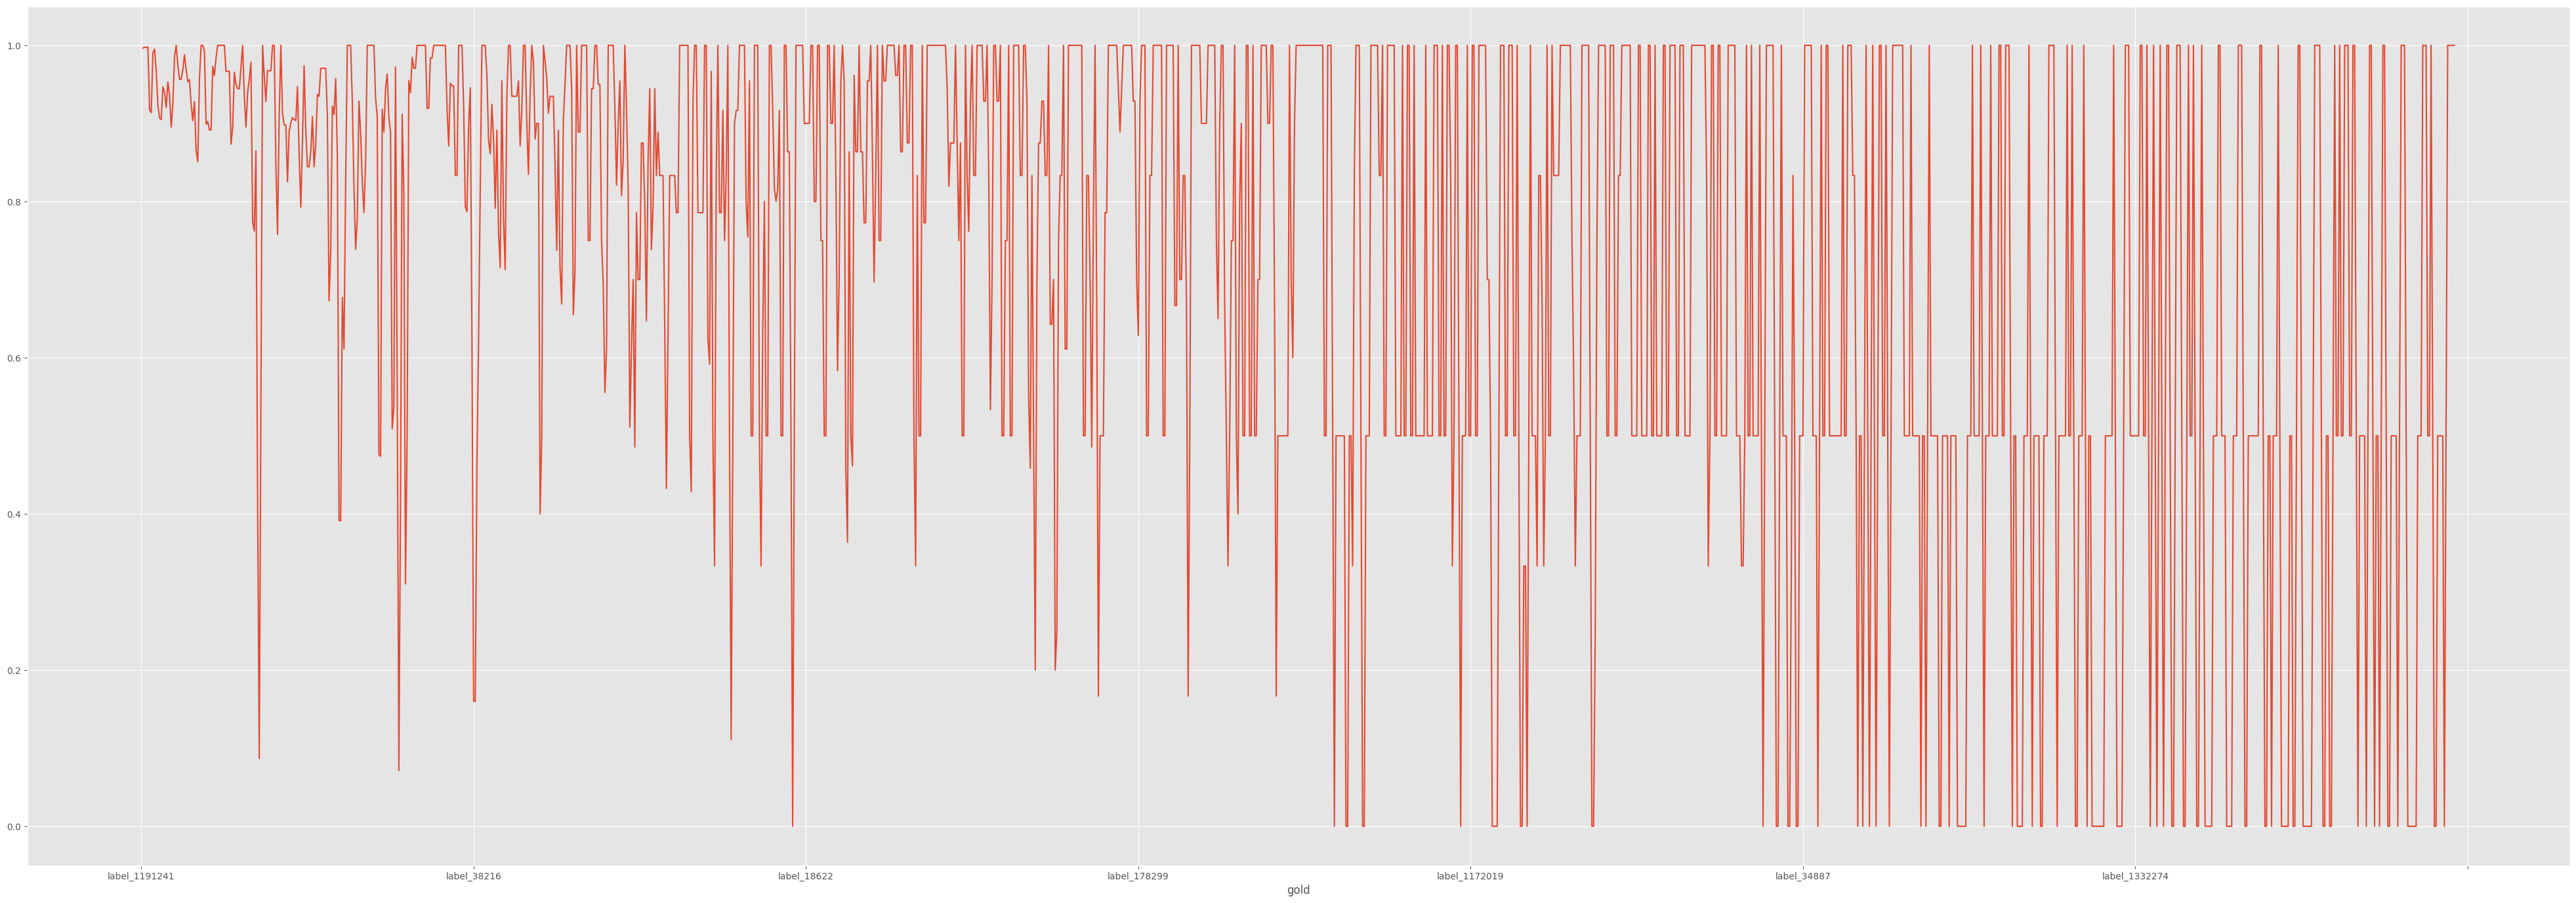

In [263]:
f1_scores = grouped_pred.sort_values(by='total', ascending=False)['f1_score']
f1_scores.rolling(2).mean().plot(figsize=(50, 17))
plt.show()

假设：
- 标签可以分为多个类别，不同类别的标签，有着不同的文本特点
- 同一类别的标签，其抽取效果与样本量的变化图像是平滑的

In [125]:
grouped_pred[grouped_pred['f1_score'] <= 0]['total'].describe()

count    324.000000
mean       2.024691
std        2.506834
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       24.000000
Name: total, dtype: float64

In [259]:
grouped_pred[(grouped_pred['total'] < 100)]['f1_score'].describe()

count    1373.000000
mean        0.709202
std         0.417451
min         0.000000
25%         0.400000
50%         1.000000
75%         1.000000
max         1.000000
Name: f1_score, dtype: float64

In [372]:
grouped_pred[grouped_pred['f1_score'] < 0.5]['total'].sum()

972

In [368]:
grouped_pred['total'].sum()

21164

In [281]:
def show_part(p):
    f1_scores = grouped_pred[p].sort_values(by='total', ascending=False)['f1_score']
    f1_scores.plot(figsize=(25, 10))
    plt.show()

18053


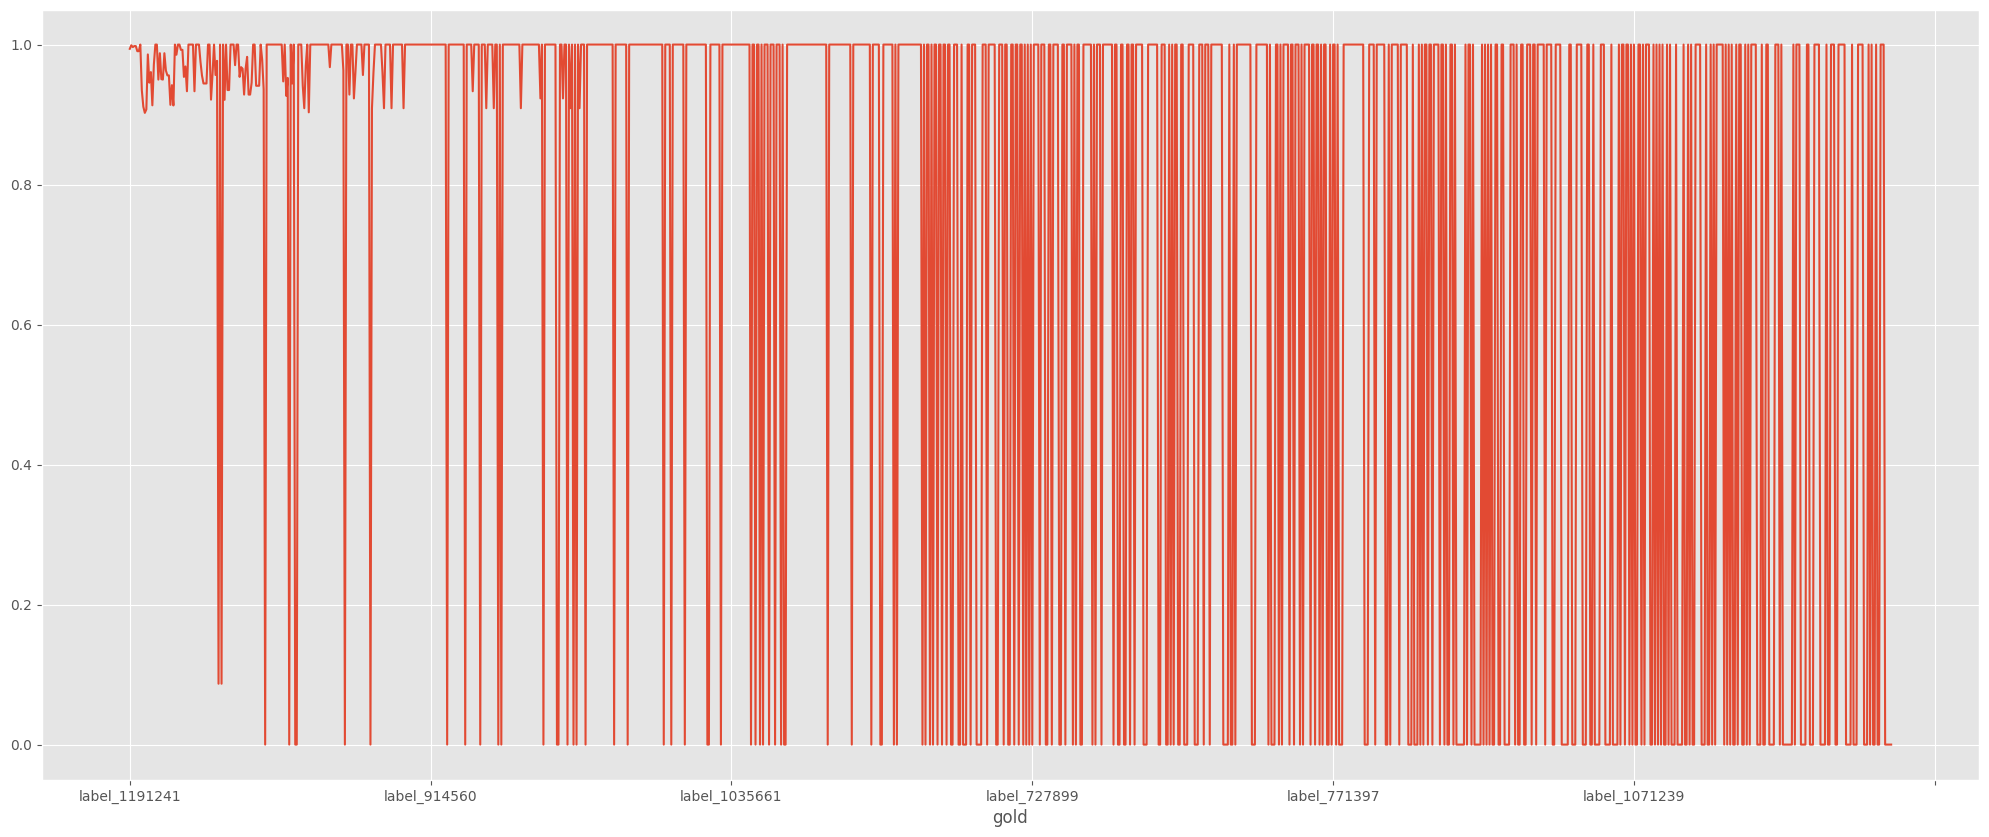

In [360]:
# 所有 f1_score=1.0的标签
part1 = (grouped_pred['f1_score'] < 0.1) | (grouped_pred['f1_score'] > 0.9)
print(grouped_pred[part1]['total'].sum())
show_part(part1)

# 三类标签的划分

In [146]:
sim_df = pd.read_pickle('temp_data/editdis_sim_df.pkl')

In [303]:
sim_set = set(sim_list)

In [326]:
part1_set = set(part1[part1].index)

In [327]:
len(sim_set), len(part1_set), len(sim_set.intersection(part1_set))

(888, 380, 225)

In [365]:
grouped_pred[(grouped_pred['f1_score'] <0.5) & (grouped_pred['total'] < 2)].sort_values(by='total', ascending=False)

,total,predicted,correct,precision,recall,f1_score
gold,,,,,,
label_1012696,1,0,0,0.0,0.0,0.0
label_558687,1,1,0,0.0,0.0,0.0
label_512620,1,0,0,0.0,0.0,0.0
label_52149,1,0,0,0.0,0.0,0.0
label_524053,1,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...
label_1459896,1,0,0,0.0,0.0,0.0
label_1498474,1,0,0,0.0,0.0,0.0
label_1498478,1,0,0,0.0,0.0,0.0


In [351]:
df_count = filtered_df.explode('label').value_counts('label') 

In [354]:
df_count[df_count < 10].sum()

1182